# GPU

Le calcul sur GPU permet de calculer plus rapidement certaines opérations mathématiques.
Il est particulièrement bien adapté pour les opérations simples entre tableaux de grandes
dimensions. Il consiste à déporter les calculs sur la carte graphique puis récupérer les résultats.
Ces transferts de données ont un coût qu'il faudra prendre en compte lors de l'utilisation
de ces co-processeurs.

On importe quelques packages pour nos exemples

In [6]:
using BenchmarkTools
using Random
using Test
using LinearAlgebra
using ForwardDiff
using ProgressMeter
using Plots

Le package principal qui permet d'utiliser est `CUDA.jl`, il permet d'utiliser les cartes 
graphiques de la marque NVIDIA.

In [10]:
using CUDA

CUDA.versioninfo()

CUDA runtime 12.3, artifact installation
CUDA driver 12.3
NVIDIA driver 545.23.8

CUDA libraries: 
- CUBLAS: 12.3.4
- CURAND: 10.3.4
- CUFFT: 11.0.12
- CUSOLVER: 11.5.4
- CUSPARSE: 12.2.0
- CUPTI: 21.0.0
- NVML: 12.0.0+545.23.8

Julia packages: 
- CUDA: 5.1.2
- CUDA_Driver_jll: 0.7.0+1
- CUDA_Runtime_jll: 0.10.1+0

Toolchain:
- Julia: 1.10.0
- LLVM: 15.0.7

1 device:
  0: Tesla V100S-PCIE-32GB (sm_70, 31.731 GiB / 32.000 GiB available)


Lorsque vous installez `CUDA.jl`, une version du compilateur de NVIDIA sera également téléchargé
sur votre poste. Il est possible d'utiliser une installation existante, c'est expliqué dans la 
documentation.

Cette première fonction permet de vérifier que le package est correctement installé et que vous disposez
de la carte graphique adéquate.

In [11]:
CUDA.functional()

true

Vous pouvez également lister les matériels à votre disposition.

In [12]:
for device in CUDA.devices()
    @show capability(device)
    @show name(device)
end

capability(device) = v"7.0.0"
name(device) = "Tesla V100S-PCIE-32GB"


Pour tester votre installation vous pouvez également regarder le package [GPUInspector.jl](https://pc2.github.io/GPUInspector.jl/dev/)

## Création de tableaux pour le GPU

### Allocations sur la carte graphique

In [13]:
a = CuArray{Float32,2}(undef, 2, 2)

2×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0
 0.0  0.0

In [14]:
similar(a)

2×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0
 0.0  0.0

In [15]:
a = CuArray([1,2,3])

3-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
 1
 2
 3

## Transfert vers le CPU

`b` est alloué sur le CPU, et un transfert de données est effectué. Deux possibilités sont offertes, transformer votre tableau en type `Array` ou utiliser la fonction `collect`.

In [18]:
b = Array(a)

3-element Vector{Int64}:
 1
 2
 3

In [19]:
collect(a)

3-element Vector{Int64}:
 1
 2
 3

### Compatibilité avec les tableaux Julia

In [20]:
CUDA.ones(2)

2-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 1.0
 1.0

In [21]:
a = CUDA.zeros(Float32, 2)

2-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.0
 0.0

In [22]:
a isa AbstractArray

true

In [23]:
CUDA.fill(42, (3,4))

3×4 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 42  42  42  42
 42  42  42  42
 42  42  42  42

## Tirages aléatoires

In [24]:
CUDA.rand(2, 2)

2×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0669919  0.579217
 0.446205   0.902117

In [25]:
CUDA.randn(2, 1)

2×1 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.6862308
 0.18606864

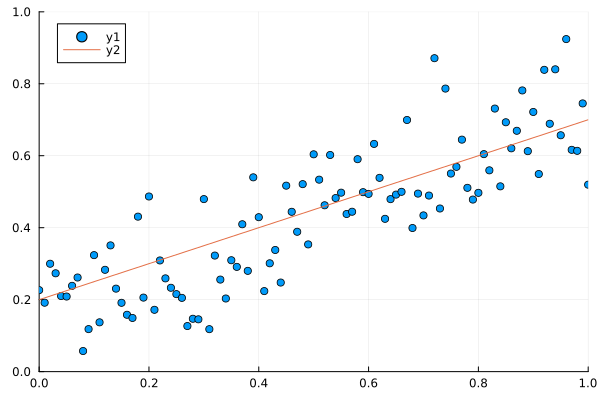

In [26]:
x = CUDA.CuArray(0:0.01:1.0)
nt = length(x)
y = 0.2 .+ 0.5 .* x + 0.1 .* CUDA.randn(nt);
scatter( Array(x), Array(y))
plot!( x -> 0.2 + 0.5x)
xlims!(0,1)
ylims!(0,1)

In [27]:
X = hcat(CUDA.ones(nt), x);

In [30]:
β = X'X \ X'y

2-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 0.1489812408196948
 0.5715402006584419

In [31]:
a = CuArray([1 2 3])

1×3 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 1  2  3

In [32]:
view(a, 2:3)

2-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
 2
 3

In [33]:
a = CuArray{Float64}([1 2 3])
b = CuArray{Float64}([4 5 6])

map(a) do x
    x + 1
end

1×3 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 2.0  3.0  4.0

In [34]:
reduce(+, a)

6.0

In [35]:
accumulate(+, b; dims=2)

1×3 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 4.0  9.0  15.0

In [36]:
findfirst(isequal(2), a)

CartesianIndex(1, 2)

In [37]:
a = CuArray([1 2 3])
b = CuArray([4 5 6])

map(a) do x
    x + 1
end

a .+ 2b

reduce(+, a)

accumulate(+, b; dims=2)

findfirst(isequal(2), a)

CartesianIndex(1, 2)

# CURAND

In [38]:
CUDA.rand!(a)

1×3 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 1285325108864083557  -4288312989882602970  7022867384820671593

# CUBLAS

Les opérations entre tableaux alloués sur le GPU sont effectués sur le co-processeur.

In [39]:
a * b'

1×1 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 7390195721257797320

# CUSOLVER

Certaines fonctions d'algèbre linéaire de LAPACK sont disponibles:

In [40]:
A =  cu([1.80   2.88   2.05  -0.89;
  5.25  -2.95  -0.95  -3.80;
  1.58  -2.69  -2.90  -1.04;
 -1.11  -0.66  -0.59   0.80])

B = cu([9.52  18.47;
 24.35   2.25;
  0.77 -13.28;
 -6.22  -6.21   ])

4×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  9.52   18.47
 24.35    2.25
  0.77  -13.28
 -6.22   -6.21

In [41]:
L, ipiv = CUDA.CUSOLVER.getrf!(A)
CUDA.CUSOLVER.getrs!('N', L, ipiv, B)

4×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  1.0  3.0
 -1.0  2.0
  3.0  4.0
 -5.0  0.999996

# CUFFT

Pour faire des FFTs sur le GPU, il est nécessaire d'utiliser les `plans` pour allouer l'espace nécessaire sur la carte graphique.

In [42]:
fft = CUFFT.plan_fft(a) 
fft * a

1×3 CuArray{ComplexF64, 2, CUDA.Mem.DeviceBuffer}:
 4.01988e18+0.0im  -8.19521e16+9.79577e18im  -8.19521e16-9.79577e18im

In [43]:
ifft = CUFFT.plan_ifft(a)
real(ifft * (fft * a))

1×3 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 1.28533e18  -4.28831e18  7.02287e18

# CUSPARSE

Les formats destinés aux matrices creuses sont aussi disponibles.

In [44]:
A = SymTridiagonal(
                [ 4.0,  10.0,  29.0,  25.0 ,  5.0], [-2.0,  -6.0,  15.0 ,  8.0])

5×5 SymTridiagonal{Float64, Vector{Float64}}:
  4.0  -2.0    ⋅     ⋅    ⋅ 
 -2.0  10.0  -6.0    ⋅    ⋅ 
   ⋅   -6.0  29.0  15.0   ⋅ 
   ⋅     ⋅   15.0  25.0  8.0
   ⋅     ⋅     ⋅    8.0  5.0

In [45]:
using SparseArrays

A = CUDA.CUSPARSE.CuSparseMatrixCSR(sparse(A))

5×5 CUDA.CUSPARSE.CuSparseMatrixCSR{Float64, Int32} with 13 stored entries:
  4.0  -2.0    ⋅     ⋅    ⋅ 
 -2.0  10.0  -6.0    ⋅    ⋅ 
   ⋅   -6.0  29.0  15.0   ⋅ 
   ⋅     ⋅   15.0  25.0  8.0
   ⋅     ⋅     ⋅    8.0  5.0

## Les étapes pour porter votre code sur GPU

1. Développez votre application sur votre CPU avec les tabeaux de type `Array`
2. Portez votre application sur GPU en utilisant le type `CuArray`
3. Desactivez "scalar indexing" pour trouver les opérations incompatibles.
4. Ecrivez vos propres kernels CUDA pour remplacer ces opérations.

## Exemple avec une regression linéaire

In [46]:
# squared error loss function
loss(w, b, x, y) = sum(abs2, y - (w*x .+ b)) / size(y, 2)
# get gradient w.r.t to `w`
loss∇w(w, b, x, y) = ForwardDiff.gradient(w -> loss(w, b, x, y), w)
# get derivative w.r.t to `b` (`ForwardDiff.derivative` is
# used instead of `ForwardDiff.gradient` because `b` is
# a scalar instead of an array)
lossdb(w, b, x, y) = ForwardDiff.derivative(b -> loss(w, b, x, y), b)

lossdb (generic function with 1 method)

In [47]:
# proximal gradient descent function
function train(w, b, x, y; lr=0.1)
    w -= lmul!(lr, loss∇w(w, b, x, y))
    b -= lr * lossdb(w, b, x, y)
    return w, b
end

train (generic function with 1 method)

Version CPU

In [48]:
function cpu_test(n = 1000, p = 100, iter = 100)
    x = randn(n, p)'
    y = sum(x[1:5,:]; dims=1) .+ randn(n)' * 0.1
    w = 0.0001 * randn(1, p)
    b = 0.0
    for i = 1:iter
       w, b = train(w, b, x, y)
    end
    return loss(w,b,x,y)
end

cpu_test (generic function with 4 methods)

In [53]:
@time cpu_test()

  0.493956 seconds (29.16 k allocations: 293.562 MiB, 6.10% gc time)


0.00844803236035335

### Version GPU

In [54]:
function gpu_test( n = 1000, p = 100, iter = 100)
    x = randn(n, p)'
    y = sum(x[1:5,:]; dims=1) .+ randn(n)' * 0.1
    w = 0.0001 * randn(1, p)
    b = 0.0
    x = CuArray(x)
    y = CuArray(y)
    w = CuArray(w)
    
    for i = 1:iter
       w, b = train(w, b, x, y)
       
    end
    return loss(w,b,x,y)
end

gpu_test (generic function with 4 methods)

In [55]:
CUDA.@time gpu_test()

  0.219352 seconds (286.71 k CPU allocations: 32.688 MiB, 1.58% gc time) (5.31 k GPU allocations: 273.907 MiB, 5.40% memmgmt time)


0.009242421749201495

# Noyaux CUDA

L'écriture directe de noyaux CUDA est possible, cependant:
- les allocations sont interdites,
- pas d'entrées-sorties donc pas d'affichage,
- si votre code n'est pas typé correctement, le code compilé sera peu performant.

Programmer vos noyaux de manière incrémentale, en les gardant le plus simple possible et en vérifiant
soigneusement que le résultat escompté est correct.

In [56]:
a = CUDA.zeros(1024)

function kernel(a)
    i = threadIdx().x
    a[i] += 1
    return
end

@cuda threads=length(a) kernel(a)

CUDA.HostKernel for kernel(CuDeviceVector{Float32, 1})

In [57]:
a = CUDA.rand(Int, 1000)

1000-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
  8726977891724946538
  8102203060114050644
 -2324662444209111707
 -2236005512266091185
  5398334102334545665
  4948735269063725833
  6903187273555962966
  7794400730534534606
   824395876830002788
  1439602654372866302
   595248745661331761
  5579557520461901172
  7997208311163723735
                    ⋮
 -8904397796379406376
 -4188108673638662386
  3852756849226548902
  -153668276667599758
 -1399699205008749530
 -1860905514385694967
 -7742877243104628179
  5953993226180949518
 -3307988546881151255
 -2175406870093928238
 -1707559153844648754
 -4040208573527860570

In [58]:
norm(a)

1.693367490961741e20

In [59]:
@btime norm($a)

  50.885 μs (119 allocations: 5.17 KiB)


1.693367490961741e20

In [60]:
@btime norm($(Array(a)))

  2.143 μs (0 allocations: 0 bytes)


1.693367490961741e20

La fonction `norm` est bien plus rapide exécutée sur le CPU

In [61]:
CUDA.allowscalar(false)

In [62]:
a = CuArray(1:9_999_999);

In [63]:
@time a .+ reverse(a);

  0.592333 seconds (1.31 M allocations: 91.360 MiB, 4.32% gc time, 89.45% compilation time)


Pour effectuer cette dernière instruction, vous avez besoin de
programmer deux noyaux.  La macro `@time` n'est pas adéquate pour
évaluer la performance car on a affaire à une opération de type
"lazy". C'est à dire que l'expression est programmée sur le GPU
mais pas exécutée. Elle le sera lorsque vous transférerez le résultat
vers le CPU. Vous pouvez utiliser `@sync` ou `@time` du package
`CUDA`.

In [64]:
@time CUDA.@sync a .+ reverse(a);

  0.000881 seconds (96 allocations: 5.828 KiB)


In [65]:
CUDA.@time a .+ reverse(a);

  0.001145 seconds (128 CPU allocations: 7.406 KiB) (2 GPU allocations: 152.588 MiB, 40.47% memmgmt time)


In [66]:
@btime CUDA.@sync $a .+ reverse($a);

  419.399 μs (74 allocations: 3.98 KiB)


In [67]:
@btime CUDA.@sync $(Array(a)) .+ reverse($(Array(a)));

  79.483 ms (4 allocations: 152.59 MiB)


## Aide au développement

Vous avez quelques macros disponibles pour vous aidez à implémenter vos noyaux:

In [68]:
kernel() = (@cuprintln("foo"); return)

kernel (generic function with 2 methods)

In [69]:
@cuda kernel()

CUDA.HostKernel for kernel()

foo


In [70]:
kernel() = (@cuprintln("bar"); return)

kernel (generic function with 2 methods)

In [71]:
@cuda kernel()

CUDA.HostKernel for kernel()

Attention, exécuter plusieurs noyaux CUDA à la suite prend du temps
car il y a un temps de lattence plus important que sur CPU.

In [72]:
a = CuArray(1:9_999_999)
c = similar(a)
c .= a .+ reverse(a);

bar


In [73]:
function vadd_reverse(c, a, b)
    i = threadIdx().x
    if i <= length(c)
        @inbounds c[i] = a[i] + reverse(b)[i]
    end
    return
end

vadd_reverse (generic function with 1 method)

Essayons de remplacer la fonction `reverse`

In [74]:
function vadd_reverse(c, a, b)
    
    i = threadIdx().x
    if i <= length(c)
        @inbounds c[i] = a[i] + b[end - i + 1]
    end
    return
end

vadd_reverse (generic function with 1 method)

Cela ne fonctionne pas car on n'itère pas sur un tableau alloué sur
un GPU de la même manière qu'un tableau alloué sur CPU.

In [75]:
@cuda threads = length(a) vadd_reverse(c, a, a)

LoadError: CUDA error: invalid argument (code 1, ERROR_INVALID_VALUE)

Les fonctions `blockIdx` et `threadIdx` sont là pour vous aider:

In [82]:
attribute(device(), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)

1024

In [83]:
function vadd_reverse(c, a, b)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if i <= length(c)
        @inbounds c[i] = a[i] + b[end - i + 1]
    end
    return
end

vadd_reverse (generic function with 1 method)

Le noyau construit est plus rapide que la fonction `reverse` initialement utilisée:

In [84]:
@btime CUDA.@sync @cuda threads=1024 blocks=length($a)÷1024+1 vadd_reverse($c, $a, $a)

  249.664 μs (19 allocations: 1.03 KiB)


CUDA.HostKernel for vadd_reverse(CuDeviceVector{Int64, 1}, CuDeviceVector{Int64, 1}, CuDeviceVector{Int64, 1})

In [85]:
@btime CUDA.@sync $a .+ reverse($a);

  422.743 μs (74 allocations: 3.98 KiB)
